In [1]:
import torch
from torchvision import transforms
import sys
import os
import os.path as osp
import numpy as np

sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'common'))

from MSCOCO import MSCOCO_orig

Fix shapedirs bug of MANO


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Check required files and directories

dataset = MSCOCO_orig.MSCOCO(transform=transform, data_split='train')

loading annotations into memory...
Done (t=26.43s)
creating index...
index created!


In [4]:
dataset.filter_and_zoom_datalist()

In [7]:
from PIL import Image
# Load image from first item in dataset
img_path = dataset.datalist[0]['img_path']
img = Image.open(img_path)

# Get crop bbox coordinates and crop image
img_cropped = img.crop(dataset.datalist[0]['crop_bbox'])
img_cropped

KeyError: 'crop_bbox'

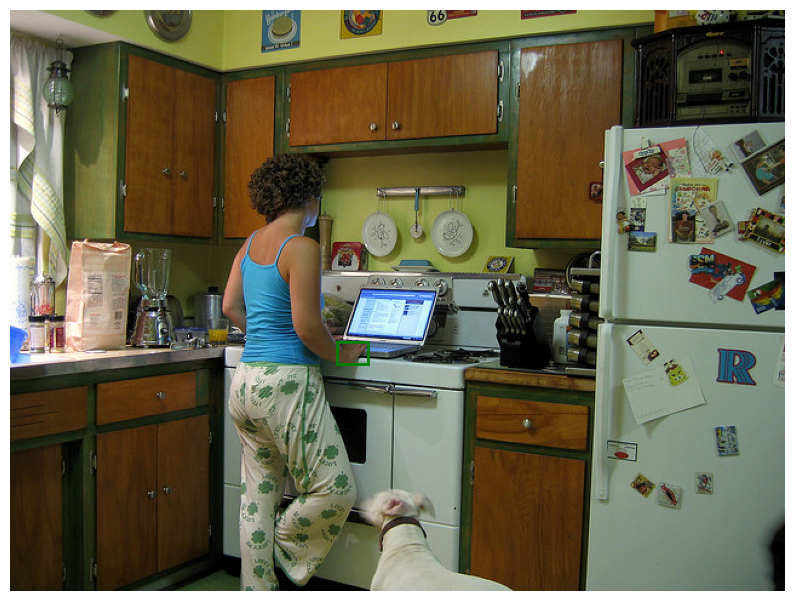

In [14]:
# Get left hand bbox coordinates
lhand_bbox = dataset.datalist[0]['rhand_bbox']

# Create figure and axis
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(10,10))

# Display image
ax.imshow(img)

# Create rectangle patch for bbox
# lhand_bbox format is [x,y,w,h]
rect = patches.Rectangle(
    (lhand_bbox[0], lhand_bbox[1]), 
    lhand_bbox[2]-lhand_bbox[0], 
    lhand_bbox[3]-lhand_bbox[1],
    linewidth=2,
    edgecolor='g',  # Changed to green to distinguish from body bbox
    facecolor='none'
)

# Add rectangle to plot
ax.add_patch(rect)

plt.axis('off')
plt.show()


In [24]:
dataset.datalist[0]['rhand_bbox']

array([269.17001343, 273.54000854, 295.05001259, 292.03000832])

In [21]:
dataset.datalist[0].keys()

dict_keys(['aid', 'img_path', 'img_shape', 'body_bbox', 'lhand_bbox', 'rhand_bbox', 'joint_img', 'joint_valid', 'mano_param'])

In [31]:
# Get items with at least 40 valid joints
bboxatleasratio = lambda bbox, img_shape, ratio: (bbox[2] - bbox[0])/img_shape[1] > ratio and (bbox[3] - bbox[1])/img_shape[0] > ratio
valid_items = [item for item in dataset.datalist 
               if item['joint_valid'].sum() >= 42 and bboxatleasratio(item['rhand_bbox'], item['img_shape'], 0.075) and bboxatleasratio(item['lhand_bbox'], item['img_shape'], 0.075)]
print(f"Found {len(valid_items)} items with at least 40 valid joints")
print(f"First item has {valid_items[0]['joint_valid'].sum()} valid joints")

Found 5148 items with at least 40 valid joints
First item has 42.0 valid joints


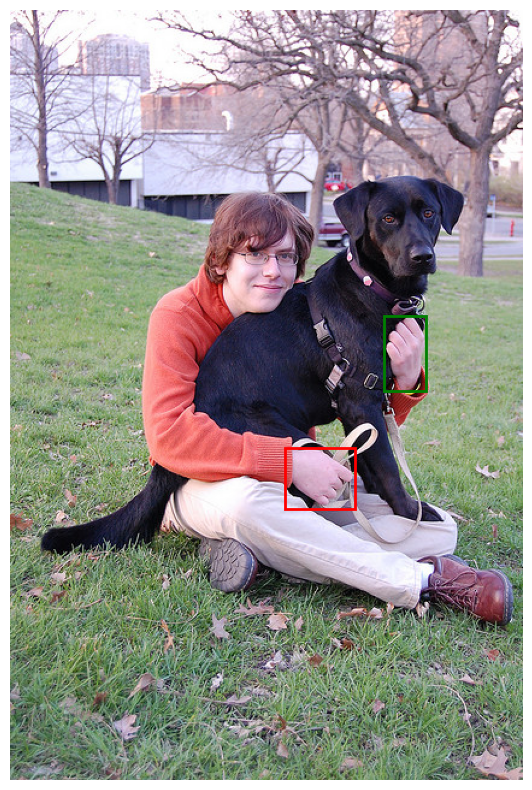

In [34]:
# Get first valid item
item = valid_items[15]

# Create figure and axis
fig, ax = plt.subplots(1, figsize=(10,10))

# Load and display image
img = Image.open(item['img_path'])
ax.imshow(img)

# Create rectangle patches for both hand bboxes
lhand_rect = patches.Rectangle(
    (item['lhand_bbox'][0], item['lhand_bbox'][1]), 
    item['lhand_bbox'][2]-item['lhand_bbox'][0], 
    item['lhand_bbox'][3]-item['lhand_bbox'][1],
    linewidth=2,
    edgecolor='g',  # Green for left hand
    facecolor='none'
)

rhand_rect = patches.Rectangle(
    (item['rhand_bbox'][0], item['rhand_bbox'][1]), 
    item['rhand_bbox'][2]-item['rhand_bbox'][0], 
    item['rhand_bbox'][3]-item['rhand_bbox'][1],
    linewidth=2, 
    edgecolor='r',  # Red for right hand
    facecolor='none'
)

# Add rectangles to plot
ax.add_patch(lhand_rect)
ax.add_patch(rhand_rect)

plt.axis('off')
plt.show()


In [13]:
dataset.datalist[0]['rhand_bbox']


array([269.17001343, 273.54000854, 295.05001259, 292.03000832])

In [19]:
from PIL import Image
img_path = dataset.datalist[0]['img_path']
img = Image.open(img_path)

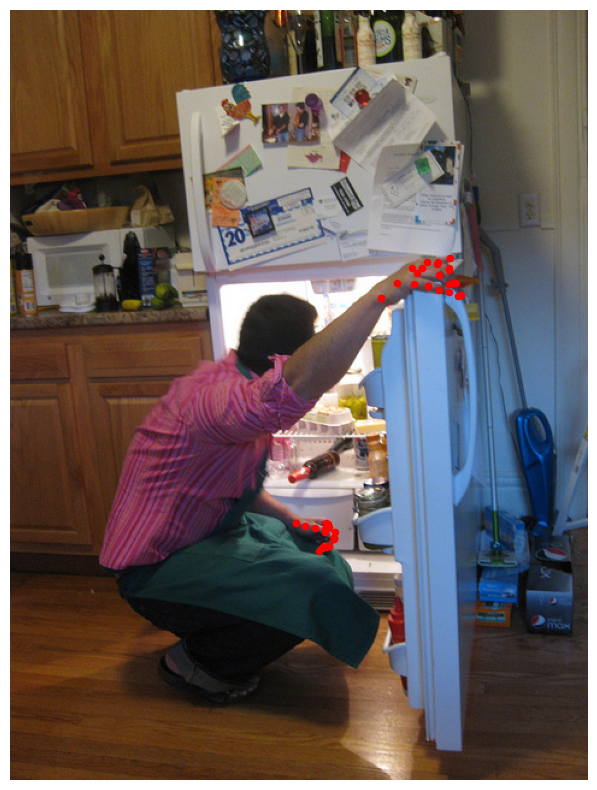

In [20]:
# Get joint coordinates and image from first item
joint_img = dataset.datalist[0]["joint_img"]
img = Image.open(dataset.datalist[0]["img_path"])

# Convert to numpy array for visualization
img_np = np.array(img)

# Plot points on image
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(img_np)

# Plot each keypoint
plt.scatter(joint_img[:,0], joint_img[:,1], c='r', s=20)

plt.axis('off')
plt.show()


In [12]:
item[1]["joint_img"][:,2]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4.], dtype=float32)

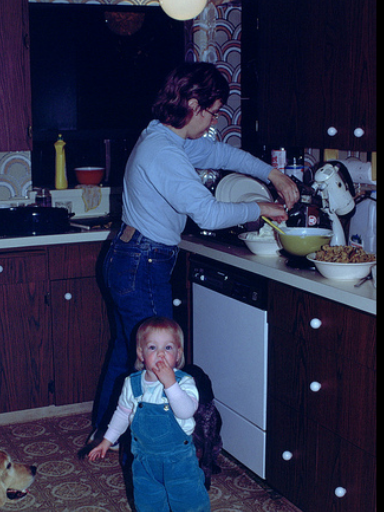

In [59]:
from PIL import Image
Image.fromarray((dataset[14][0]['img'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))

In [65]:
item = dataset[0]

In [68]:
item[2]['bb2img_trans']

array([[ 9.7519535e-01,  9.2518588e-18,  3.5902496e+01],
       [-7.4014871e-17,  9.7519529e-01,  1.4212000e+02]], dtype=float32)

In [71]:
dataset.datalist[0]['joint_img'].shape


(42, 2)

In [75]:
item[0]['img'].shape


torch.Size([3, 512, 384])

In [77]:
xmin, xmax = joint_img[:,0].min(), joint_img[:,0].max()
ymin, ymax = joint_img[:,1].min(), joint_img[:,1].max()
print(f"X range: {xmin:.2f} to {xmax:.2f}")
print(f"Y range: {ymin:.2f} to {ymax:.2f}")

X range: 267.02 to 400.63
Y range: 343.01 to 579.98


In [69]:
from utils.vis import vis_keypoints_with_skeleton
from utils.mano import mano

# Get the image and joint data from dataset[0]
img = (item[0]['img'].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
img = img[:,:,::-1]  # Convert RGB to BGR for OpenCV

# Get joint coordinates and transform them to image space
joint_img = dataset.datalist[0]['joint_img']  # Get joints
joint_img_xy1 = np.concatenate((joint_img[:,:2], np.ones_like(joint_img[:,:1])), 1)
joint_img = np.dot(item[2]['bb2img_trans'], joint_img_xy1.transpose(1,0)).transpose(1,0)

# Draw skeleton
vis_img = img.copy()
# Right hand (purple)
vis_img = vis_keypoints_with_skeleton(vis_img, joint_img[:21], mano.sh_skeleton, (255,0,255))
# Left hand (green)
vis_img = vis_keypoints_with_skeleton(vis_img, joint_img[21:], mano.sh_skeleton, (102,255,102))

# Display using PIL
Image.fromarray(vis_img[:,:,::-1])  # Convert back to RGB for PIL

# Save if desired
output_path = "output_with_joints.jpg"
Image.fromarray(vis_img[:,:,::-1]).save(output_path)
print(f"Saved image with joints to {output_path}")

Saved image with joints to output_with_joints.jpg


In [45]:
from config import cfg
import cv2

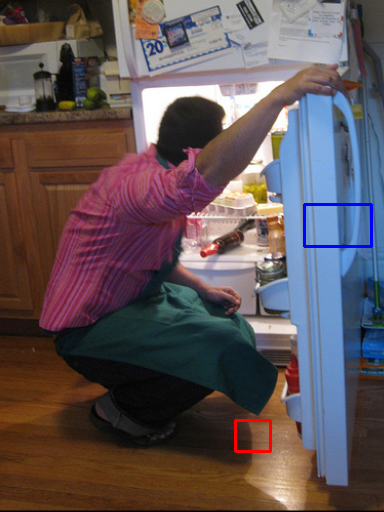

In [51]:
img = (item[0]['img'].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

# Get bounding box data from item[2]['bb2img_trans']
bb2img_trans = item[2]['bb2img_trans']

# Get hand bbox centers and sizes from item[1]
lhand_bbox_center = item[1]['lhand_bbox_center']
lhand_bbox_size = item[1]['lhand_bbox_size']
rhand_bbox_center = item[1]['rhand_bbox_center'] 
rhand_bbox_size = item[1]['rhand_bbox_size']

# Convert bbox coordinates back to image space
def convert_to_image_space(center, size):
    # Convert from network output space to input image space
    bbox = np.array([
        [center[0] - size[0]/2, center[1] - size[1]/2],
        [center[0] + size[0]/2, center[1] + size[1]/2]
    ])
    bbox[:,0] = bbox[:,0] / cfg.output_body_hm_shape[2] * cfg.input_img_shape[1]
    bbox[:,1] = bbox[:,1] / cfg.output_body_hm_shape[1] * cfg.input_img_shape[0]
    # Add homogeneous coordinates
    bbox = np.concatenate((bbox, np.ones((2,1))), 1)
    # Transform back to original image space
    bbox = np.dot(bb2img_trans, bbox.transpose(1,0)).transpose(1,0)
    return bbox.astype(int)

# Draw boxes
img_with_boxes = img.copy()

# Left hand box (blue)
lhand_bbox = convert_to_image_space(lhand_bbox_center, lhand_bbox_size)
cv2.rectangle(img_with_boxes, tuple(lhand_bbox[0]), tuple(lhand_bbox[1]), (255,0,0), 2)

# Right hand box (red)
rhand_bbox = convert_to_image_space(rhand_bbox_center, rhand_bbox_size)
cv2.rectangle(img_with_boxes, tuple(rhand_bbox[0]), tuple(rhand_bbox[1]), (0,0,255), 2)

# Display using PIL
Image.fromarray(img_with_boxes)

In [48]:
# Save the image with boxes
output_path = "output_with_boxes.jpg"
Image.fromarray(img_with_boxes).save(output_path)
print(f"Saved image with bounding boxes to {output_path}")


Saved image with bounding boxes to output_with_boxes.jpg
